# Imports

In [1]:
import torch
import numpy as np

from DKL.data.dataset import generate_2d_data
import DKL.data.transformations as f
from DKL.training.main_trainer import train_joint_model
from DKL.training.extra_trainer import train_naive_gp
from DKL.training.extra_trainer import train_ideal_gp
from DKL.utils.display import test_new_realization, plotting

# Seed Definition

In [2]:
torch.manual_seed(43)
np.random.seed(43)

# Device

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Data Generation

In [11]:
## Hyperparameters for synthetic guassian process generation

N_training = 1200 
test_grid_size = 16
noise_level = 0.05
scale = 5.0
function = f.transform_sin
lengthscale = 12.0

# Generate multiple data realizations on random points
common_data, realization = generate_2d_data(function, lengthscale= lengthscale,
                                             n_train_points= N_training , 
                                             test_grid_size=test_grid_size, 
                                             scale=scale, noise_level=noise_level, 
                                             device=device)

  - 1200 random training points per realization
  - 16x16 visualization grid (256 points) for testing
Y Stats (train) min=-1.9004, max=2.4212, mean=0.5176, std=0.8196
Y Stats (test grid) min=-1.5421, max=1.9911, mean=0.5094, std=0.8234
Data generation complete.


In [ ]:
## Hyperparameters for Normalizing Flow and Gaussian process Learning

num_epochs = 15
flow_learning_rate = 0.001 # Separate learning rate for flow
gp_learning_rate = 0.01 # Separate learning rate for GP/Likelihood (can be different)
num_flow_blocks = 12 # Number of blocks in the RealNVP flow model
freeze_gp_params = False # Set to True to freeze GP/Likelihood params during joint training
nouvel_entrainement = True # Set to True to start fresh training, False to resume from checkpoint
if nouvel_entrainement:
    %rm -rf ../models/*

# Train the joint model with separate learning rates
trained_flow, trained_gp, trained_likelihood, loss_history  = train_joint_model(common_data,
                                                                                realization,
                                                                                num_epochs=num_epochs, 
                                                                                flow_lr=flow_learning_rate, 
                                                                                gp_lr=gp_learning_rate,
                                                                                device = device,
                                                                                num_flow_blocks=num_flow_blocks,
                                                                                patience=50, delta = 0.001, 
                                                                                no_learn_lengthscale=freeze_gp_params)


RealNVP model created with 12 affine blocks.
MLP output layers initialized to zeros for near-identity transform.
No checkpoint found. Starting training from scratch.

Starting training...


100%|██████████| 15/15 [00:02<00:00,  7.02it/s]


Training finished.
Loading best joint model from /Users/solal/Desktop/DKL/models/learned_gp_checkpoint.pth for final return...


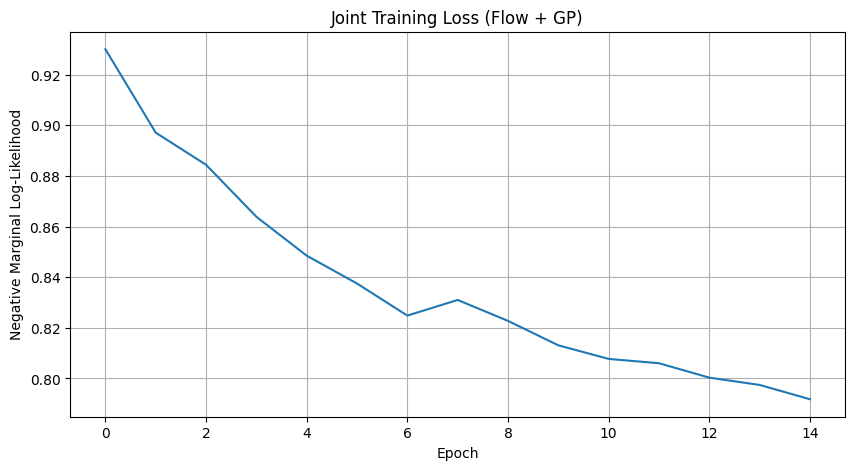

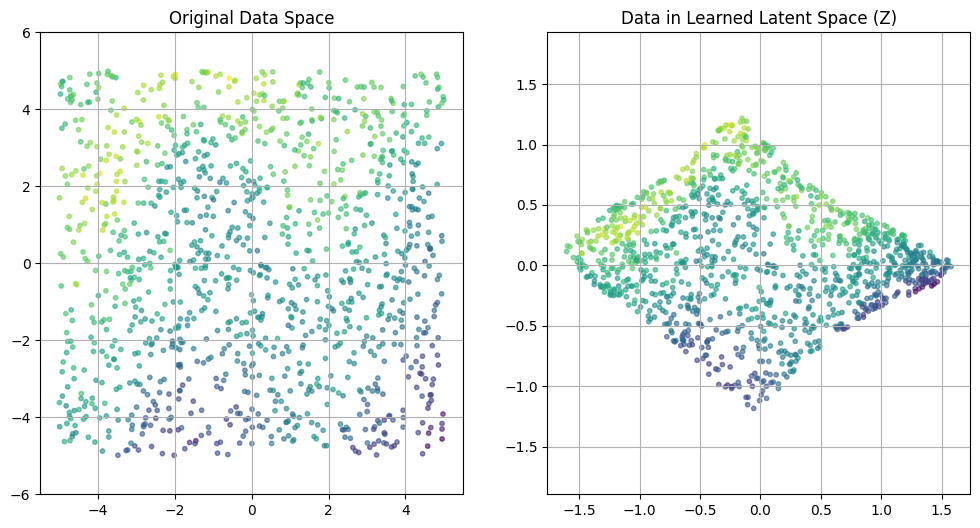

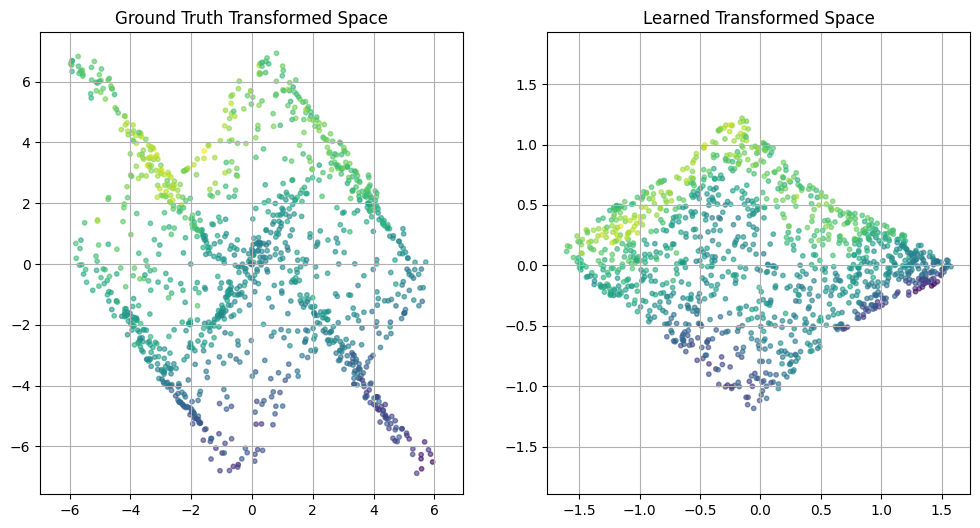


Generating visualization grid for learned transformation...


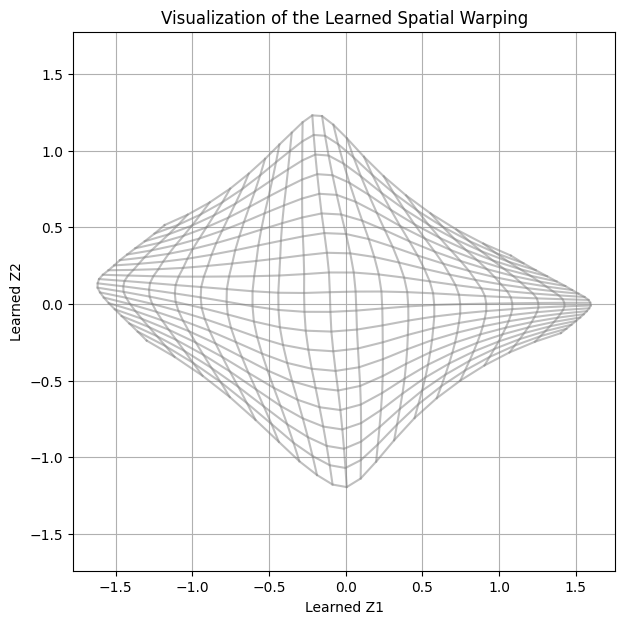

In [6]:
plotting(trained_flow,trained_gp,trained_likelihood,
         common_data, realization,
        function,loss_history,scale
        )

## Naive and Ideal Gaussian Processes

In [ ]:
naive_gp_model, naive_likelihood = train_naive_gp(common_data, realization,
                                                device = device, 
                                                num_epochs=100,lr=0.1, 
                                                checkpoint_name='naive_gp_checkpoint.pth')


No Naive GP checkpoint found. Starting training from scratch.
Training Naive GP on original data for 100 epochs (starting at 0)...


 11%|█         | 11/100 [00:00<00:06, 14.68it/s]

  Naive GP Epoch 10/100: Loss 0.5681, Lengthscale: [[1.289573]], Outputscale: 0.3259, Noise: 0.3118
  Best loss detected and epoch eligible for saving.


 23%|██▎       | 23/100 [00:01<00:05, 15.01it/s]

  Naive GP Epoch 20/100: Loss 0.2083, Lengthscale: [[1.9135058]], Outputscale: 0.2093, Noise: 0.1253
  Best loss detected and epoch eligible for saving.


 31%|███       | 31/100 [00:02<00:04, 14.31it/s]

  Naive GP Epoch 30/100: Loss 0.0228, Lengthscale: [[2.2390926]], Outputscale: 0.3043, Noise: 0.0537
  Best loss detected and epoch eligible for saving.


 45%|████▌     | 45/100 [00:03<00:03, 13.92it/s]

Early Stopping triggered at epoch 46! No improvement for 10 epochs.
Naive GP training complete.
Loading best Naive GP model from /Users/solal/Desktop/DKL/models/naive_gp_checkpoint.pth for final return...


In [ ]:
ideal_gp_model, ideal_likelihood =  train_ideal_gp(common_data, realization,
                                                    function, lengthscale = lengthscale,
                                                    device = device,
                                                    num_epochs=100,lr=0.1,
                                                    checkpoint_name='ideal_gp_checkpoint.pth')

No Transformed GP checkpoint found. Starting training from scratch.
Training Transformed GP for 100 epochs (starting at 0)...


 12%|█▏        | 12/100 [00:00<00:06, 13.77it/s]

  Transformed GP Epoch 10/100: Loss 0.5524, Lengthscale: [[1.2946628]], Outputscale: 0.3261, Noise: 0.3120
  Best loss detected and epoch eligible for saving.


 22%|██▏       | 22/100 [00:01<00:05, 13.90it/s]

  Transformed GP Epoch 20/100: Loss 0.1842, Lengthscale: [[1.9753448]], Outputscale: 0.1863, Noise: 0.1253
  Best loss detected and epoch eligible for saving.


 32%|███▏      | 32/100 [00:02<00:04, 13.64it/s]

  Transformed GP Epoch 30/100: Loss -0.0118, Lengthscale: [[2.5641227]], Outputscale: 0.1876, Noise: 0.0530
  Best loss detected and epoch eligible for saving.


 43%|████▎     | 43/100 [00:03<00:04, 13.90it/s]

Early Stopping triggered at epoch 44! No improvement for 10 epochs.
Transformed GP training complete.
Loading best Ideal GP model from /Users/solal/Desktop/DKL/models/ideal_gp_checkpoint.pth for final return...


## Performances comparisons


--- Testing with Existing Test Grid ---
Using the initial test grid data from generation...
Predicting and Sampling from Learned GP on test grid...


GP Predictions: 100%|██████████| 2/2 [00:00<00:00,  8.92it/s]


Predicting and Sampling from Guessed (Naive) GP on test grid...


GP Predictions: 100%|██████████| 2/2 [00:00<00:00, 19.65it/s]


Predicting and Sampling from True Transformed (Ideal) GP on test grid...


GP Predictions: 100%|██████████| 2/2 [00:00<00:00, 14.44it/s]



Calculating MSE on Initial Test Grid Data...
MSE (Learned Non-Stationary GP) vs True Test Grid: 0.035652
MSE (Best Stationary GP in Original Space) vs True Test Grid: 0.006155
MSE (Stationary GP on TRUE Transformed Space) vs True Test Grid: 0.003112

Plotting Predictions Comparison on Initial Test Grid...


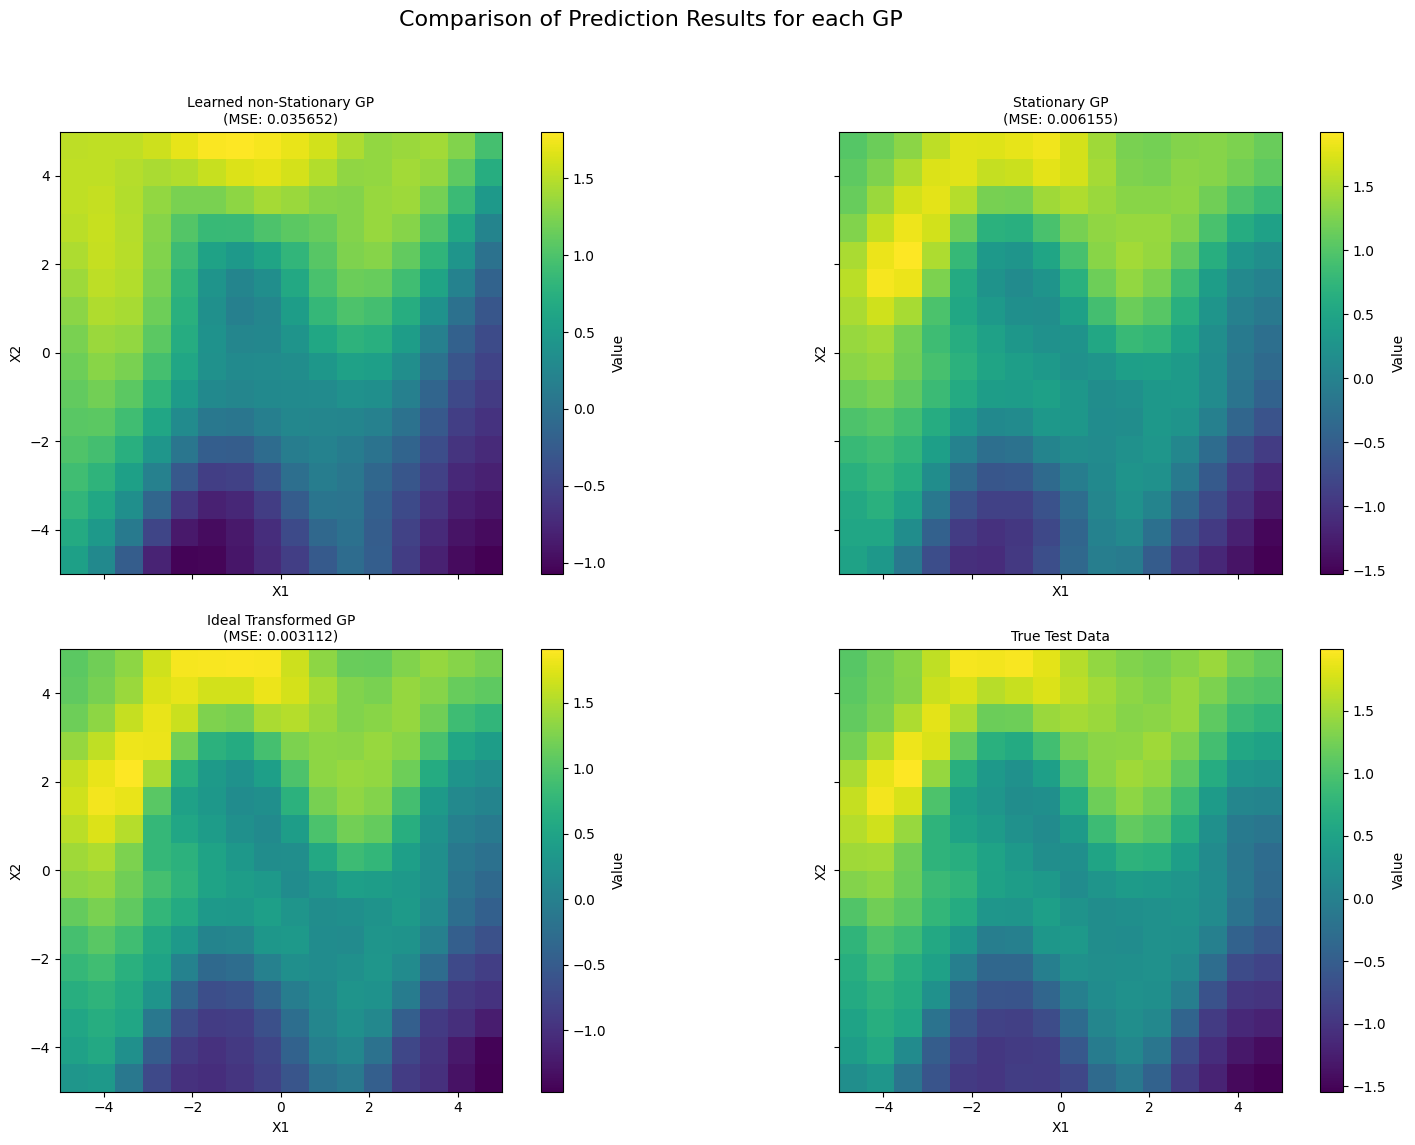


Plotting Variances Comparison on Initial Test Grid...


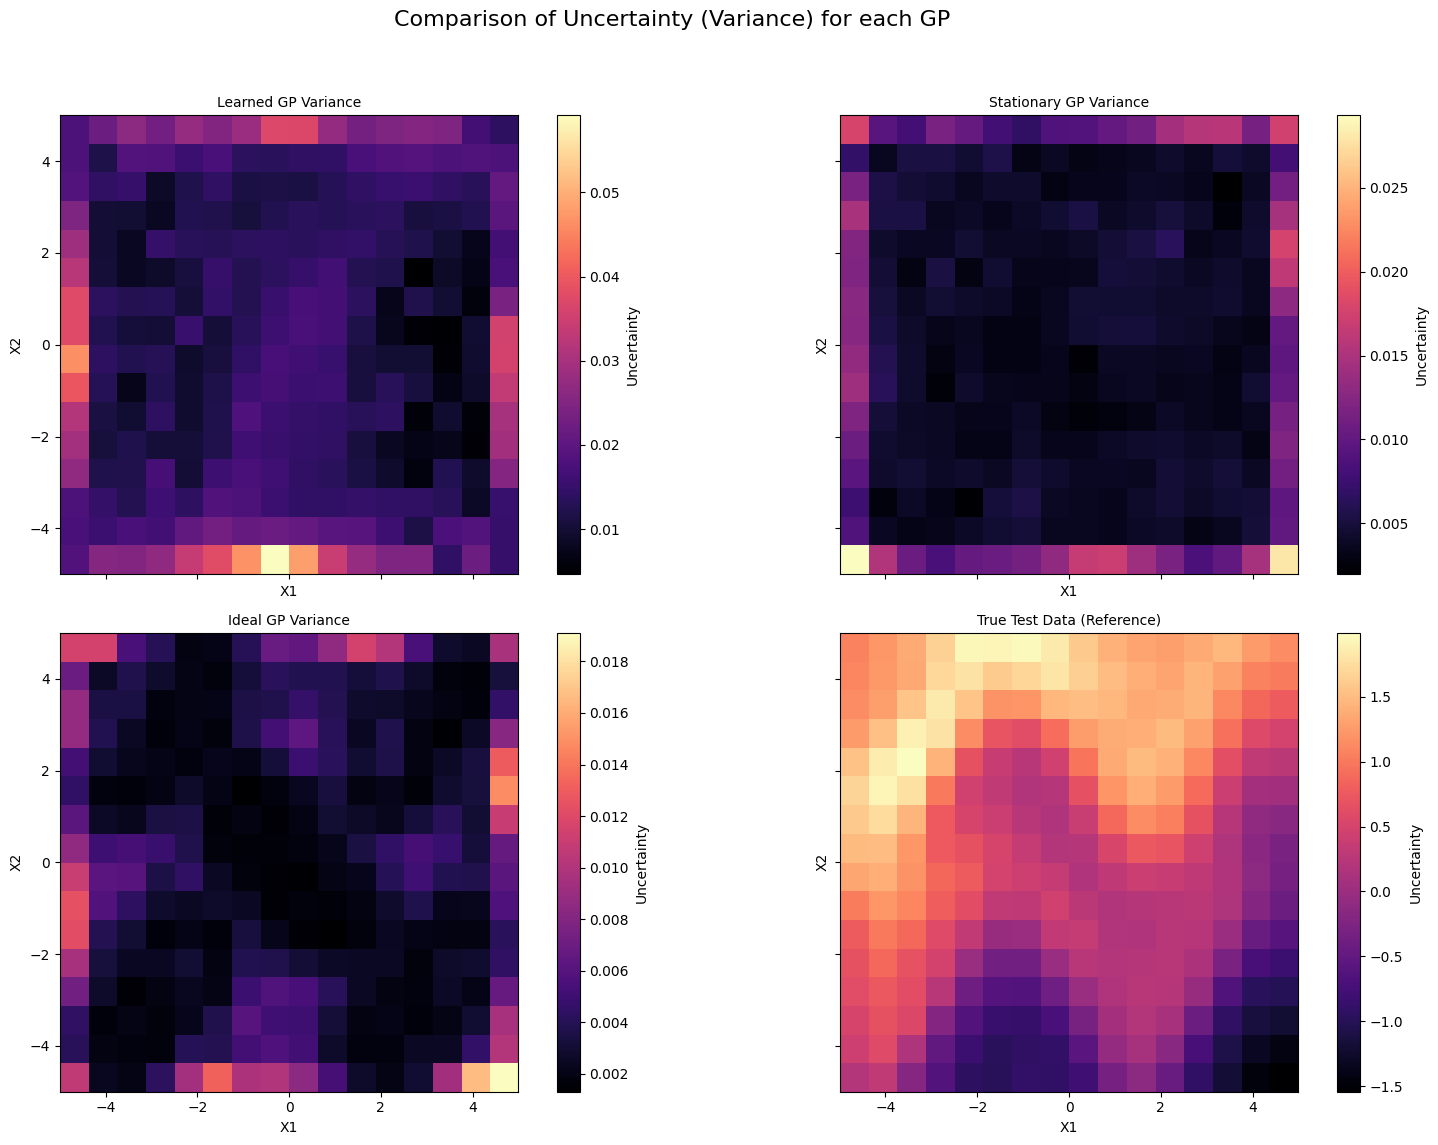


Plotting CRPS Comparison on Initial Test Grid...


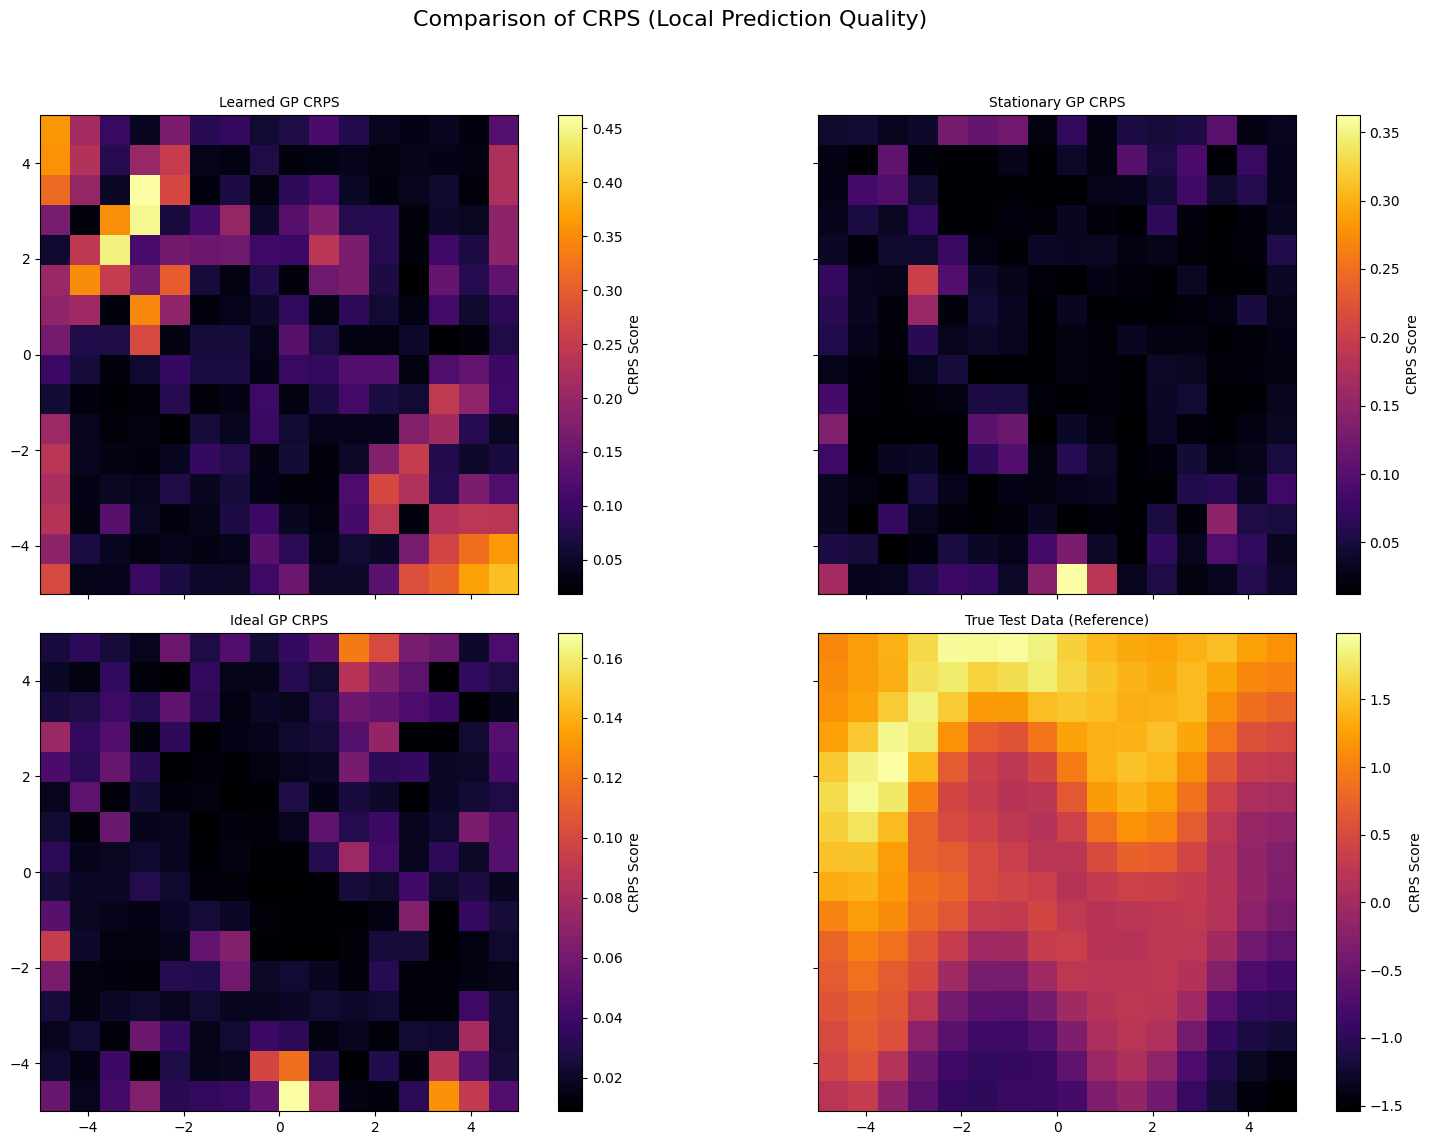

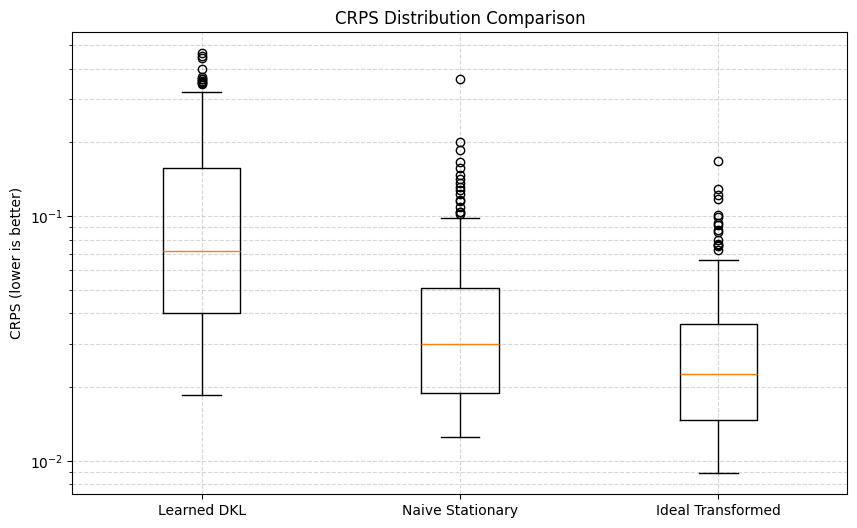

Evaluation finished.


In [ ]:
test_new_realization(trained_flow, trained_gp,
                     trained_likelihood, naive_gp_model,
                     naive_likelihood, ideal_gp_model, ideal_likelihood,
                     common_data, realization, scale)